In [1]:
import os
import uuid

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from PIL import Image

In [10]:
data = "../data"
datasets = ['DeepGlobe-dataset', "Massachusetts-roads-dataset"]
dataset_out = "../data/big-dataset"

In [11]:
im = Image.open(os.path.join(data, datasets[0], "train", "104_mask.png"))
im.size

(1024, 1024)

In [13]:
# get patches of size (400, 400) from the image
def get_patches(im, size):  # sourcery skip: for-append-to-extend
    patches = []
    for i in range(0, im.size[0] - size[0], size[0]//2):
        for j in range(0, im.size[1] - size[1], size[1]//2):
            patches.append(im.crop((i, j, i + size[0], j + size[1])))
    return patches

patches = get_patches(im, (400, 400))

# Generate Patches from DeepGlobe
This Dataset can be downloaded here: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset

In [14]:
dataset = datasets[0]

# get unique names
fnames = os.listdir(os.path.join(data, dataset, "train"))
fnames = list({name.split("_")[0] for name in fnames})

In [18]:
for fname in tqdm(fnames):
    img = Image.open(os.path.join(data, dataset, "train", f"{fname}_sat.jpg"))
    target = Image.open(os.path.join(data, dataset, "train", f"{fname}_mask.png"))

    # get patches of size (400, 400) from the image
    img_patches = get_patches(img, (400, 400))
    target_patches = get_patches(target, (400, 400))

    # save patches to disk
    idx = uuid.uuid4()
    for i in range(len(img_patches)):
        if np.sum(target_patches[i]) > 0:
            img_patches[i].save(os.path.join(dataset_out, "DeepGlobe", "images", f"{idx}-{i}.jpg"))
            target_patches[i].save(os.path.join(dataset_out, "DeepGlobe", "groundtruth", f"{idx}-{i}-mask.png"))

100%|██████████| 6226/6226 [12:01<00:00,  8.63it/s]


# Generate Patches from MRD
This dataset can be downloaded here: https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset

In [20]:
dataset = f"{datasets[1]}/tiff"
dataset_out = dataset_out


for split in ["train", "test", "val"]:
    # get unique names
    fnames = os.listdir(os.path.join(data, dataset, split))
    
    for fname in tqdm(fnames):
        # load .tiff image
        img = Image.open(os.path.join(data, dataset, split, fname))

        # img = Image.open(os.path.join(data, dataset, "train", f"{fname}"))
        target = Image.open(os.path.join(data, dataset, f"{split}_labels", f"{fname}"[:-1]))

        # get patches of size (400, 400) from the image
        img_patches = get_patches(img, (400, 400))
        target_patches = get_patches(target, (400, 400))

        idx = uuid.uuid4()
        for i in range(len(img_patches)):
            keep = np.array(img_patches[i]).mean(axis=-1) > 254
            s = np.sum(keep)
            if s < 100 and np.sum(target_patches[i]) > 0:
                img_patches[i].save(os.path.join(dataset_out, "MRD", "images", f"{idx}-{i}.jpg"))
                target_patches[i].save(os.path.join(dataset_out, "MRD", "groundtruth", f"{idx}-{i}-mask.png"))

100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


# Prepare CIL Data

In [21]:
data = "../data/big-dataset"
dataset = "CIL"
load_data = "../data/CIL-dataset/training"

for fname in tqdm(os.listdir(os.path.join(load_data, "images"))):
    if fname.endswith(".png"):
        img = Image.open(os.path.join(load_data, "images", fname))
        target = Image.open(os.path.join(load_data, "groundtruth", fname))

        # convert image to jpg
        img = img.convert("RGB")
        target = target.convert("RGB")
        
        img.save(os.path.join(data, dataset, "images", f"{fname.split('.')[0]}.jpg"))
        target.save(os.path.join(data, dataset, "groundtruth", f"{fname.split('.')[0]}-mask.png"))

100%|██████████| 144/144 [00:02<00:00, 66.46it/s]


# Explore Datasets

In [26]:
data = "../data/big-dataset"
df = []

for dataset in ["MRD", "DeepGlobe", "CIL"]:
    masks = os.listdir(os.path.join(data, dataset, "groundtruth"))
    for i, mask in tqdm(enumerate(masks), total=len(masks)):
        if mask.endswith("-mask.png"):
            n_pixels = np.sum(np.array(Image.open(os.path.join(data, dataset, "groundtruth", mask))) > 0)
            df.append((mask, dataset, n_pixels))

100%|██████████| 144/144 [00:00<00:00, 535.01it/s]


In [27]:
dataframe = pd.DataFrame(df, columns=["filename", "dataset", "n_pixels"])
dataframe.head()

,filename,dataset,n_pixels
0,b2b966ab-1846-4c7f-9c0e-a4c96e89629b-10-mask.png,MRD,13833
1,4c3dc67d-f82c-4721-81d8-5bafab305253-17-mask.png,MRD,11472
2,62995f6c-9a6b-4ae9-9afc-fde70617c195-23-mask.png,MRD,6512
3,f1197155-776c-4d8f-898f-09b1eec8b8cf-16-mask.png,MRD,5612
4,aeac50cb-4f6f-4c48-99d1-c1fd045e59dd-1-mask.png,MRD,9377


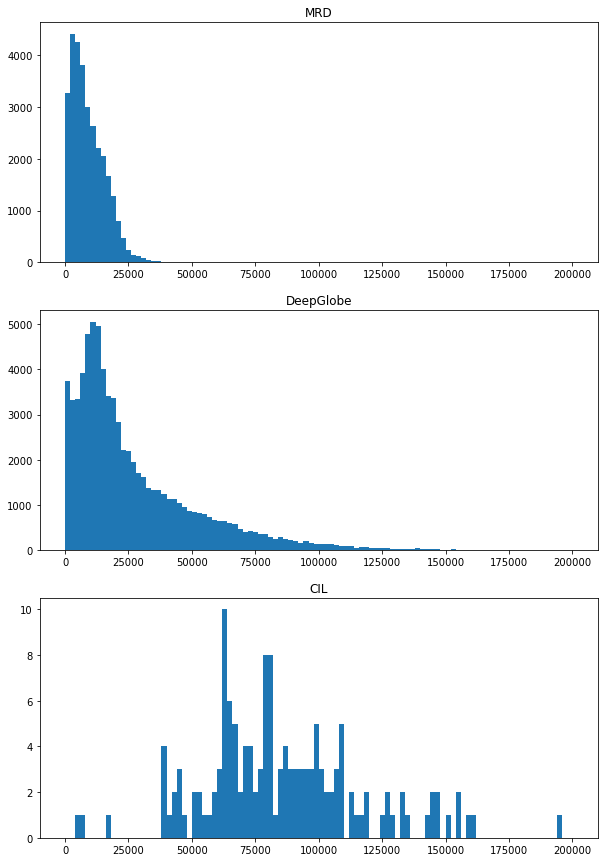

In [28]:
# plot hist per dataset of n_pixels in different plots using plt
plt.figure(figsize=(10, 15))
for i, dataset in enumerate(["MRD", "DeepGlobe", "CIL"]):
    plt.subplot(3, 1, i + 1)
    plt.hist(dataframe[dataframe["dataset"] == dataset]["n_pixels"], bins=100, range=(0, 200000))
    plt.title(dataset)

In [29]:
# count how many masks have more than count pixels
count = 10000
dataframe[dataframe["n_pixels"] > count].groupby("dataset").count()


,filename,n_pixels
dataset,,
CIL,142,142
DeepGlobe,56006,56006
MRD,11800,11800


# Create overview csv

In [81]:
# create dataframe containing all paths to the images
data = "../data/big-dataset"
df = []

for dataset in ["CIL", "DeepGlobe", "MRD"]:
    images = os.listdir(os.path.join(data, dataset, "images"))
    for i, img in tqdm(enumerate(images), total=len(images)):
        fname = img.split(".")[0]
        fpath = os.path.join(dataset, "images", img)
        mask_path = os.path.join(dataset, "groundtruth", f"{fname}-mask.png")
        df.append((fname, dataset, fpath, mask_path, "train"))
        

df = pd.DataFrame(df, columns=["filename", "dataset", "fpath", 'mpath', "split"])
df.head()

100%|██████████| 30540/30540 [00:00<00:00, 471129.71it/s]


,filename,dataset,fpath,mpath,split
0,satimage_132,CIL,CIL/images/satimage_132.jpg,CIL/groundtruth/satimage_132-mask.png,train
1,satimage_126,CIL,CIL/images/satimage_126.jpg,CIL/groundtruth/satimage_126-mask.png,train
2,satimage_41,CIL,CIL/images/satimage_41.jpg,CIL/groundtruth/satimage_41-mask.png,train
3,satimage_55,CIL,CIL/images/satimage_55.jpg,CIL/groundtruth/satimage_55-mask.png,train
4,satimage_69,CIL,CIL/images/satimage_69.jpg,CIL/groundtruth/satimage_69-mask.png,train


In [82]:
df.to_csv("../data/big-dataset/dataset.csv", index=False)